# Exemples et tests d'utilisation du systeme de Primitive de PyPot
* [Documentation sur les primitives](http://nbviewer.ipython.org/github/poppy-project/pypot/blob/master/samples/notebooks/Controlling%20a%20Poppy%20humanoid%20in%20V-REP%20using%20pypot.ipynb#Using-primitives)
* [Exemples d'utilisation des primitives (notebook)](http://nbviewer.ipython.org/github/poppy-project/pypot/blob/master/samples/notebooks/Controlling%20a%20Poppy%20humanoid%20in%20V-REP%20using%20pypot.ipynb#Using-primitives)
* [Primitive de bases inclues dans pypot (github)](https://github.com/poppy-project/pypot/tree/master/pypot/primitive)
* [Primitives inclues dans Poppy_humanoïde](https://github.com/poppy-project/poppy-humanoid/tree/master/software/poppy_humanoid/primitives)

In [1]:
#imports and initilaize virutal poppy using vrep
from pypot.vrep import from_vrep
from poppy.creatures import PoppyHumanoid
robot = PoppyHumanoid(simulator='vrep')

In [ ]:
#import and initialize physical poppy
from poppy.creatures import PoppyHumanoid
robot = PoppyHumanoid()

In [ ]:
#Rend le robot mou et deconnecte les moteurs
for m in robot.motors:
    m.compliant = True
robot.close()

## Primitives de sécurité
Activation des deux primitives de sécurités fournies avec la poppy_humanoïde, elle permettent d'eviter les dmages sur les moteurs, notement dus a leur surchauffe.
* **LimitTorque** : limite le couple appliqué sur le les moteurs, evite leur surcauffe mais aussi de casser des pieces.
* **TemperatureMonitor** : Surveille la temperature des moteur, joue un son et affiche une alerte lorsque la temperature de certains moteurs atteind la limite fixée.

Ces deux primitives devraient être activées au debut de nimporte quelle utilisation de poppy.

In [5]:
from poppy_humanoid.primitives.safe import LimitTorque
plimit_torque = LimitTorque(robot)
plimit_torque.start()

In [6]:
from poppy_humanoid.primitives.safe import TemperatureMonitor
ptemp_monitor = TemperatureMonitor(robot,temp_limit=50, sound="/opt/sounds/ouch.wav")
ptemp_monitor.start()

ImportError: cannot import name TemperatureMonitor

### Moniteur de temperature custom
Le moniteur de temperature fournis est sympa mais si pour une raison 
ou une autre l'opérateur de Poppy de vois/entend pas l'alerte cela risque de causer des
domages irreversible sur les moteurs. Cette version propose de rendre rendre "mou" puis totalement inactif
les moteurs qui seraient chaud depuis trop longtemps.

In [2]:
from datetime import datetime, timedelta
import pypot

class CustomTemperatureMonitor(pypot.primitive.LoopPrimitive):
    '''
        This primitive raises an alert by playing a sound when the temperature
        of one motor reaches the "temp_limit".
        
        If a motor reaches the limit since more than "time_reduce_torque" seconds
        the torc of this motor will be reduced to "small_torque".
        
        If a motor reaches the limit since more than "time_compliant" seconds
        this motor will be made compliant.

        On MacOS "Darwin" you can use "afplay" for player
        On windows vista+, you can maybe use "start wmplayer"
        '''
    def __init__(self, robot, freq=0.5, temp_limit=50, 
                 time_reduce_torque=30, small_torque=45, 
                 time_compliant=90, player='aplay', sound=None):
        
        pypot.primitive.LoopPrimitive.__init__(self, robot, freq)

        self.temp_limit = temp_limit
        self.time_reduce_torque = time_reduce_torque
        self.time_compliant = time_compliant
        self.small_torque = small_torque
        self.player = player
        self.sound = sound
        self._overheat_time = {}

    def setup(self):
        pass

    def update(self):
        self.check_temperature()

    def teardown(self):
        pass

    def check_temperature(self):
        motor_list = []

        for m in self.robot.motors:
            if m.present_temperature > self.temp_limit:
                motor_list.append(m)
                if m not in self._overheat_time:
                    self._overheat_time[m] = datetime.now()
            else:
                if m in self._overheat_time:
                    del(self._overheat_time[m])

        if len(motor_list) > 0:
            self.raise_problem(motor_list)
        
        for m,t in self._overheat_time.items():
            if (datetime.now() - t) > timedelta(seconds = self.time_compliant):
                print('/!\ Making {} compliant !'.format(m.name))
                m.compliant = True

            elif(datetime.now() - t) > timedelta(seconds = self.time_reduce_torque):
                print('/!\ Reducing torque of {} to {}'.format(m.name,min(m.torque_limit,self.small_torque)))
                m.torque_limit = min(m.torque_limit,self.small_torque)

    def raise_problem(self, motor_list):
        subprocess.call([self.player, self.sound])

        for m in motor_list:
            print('{} overheating: {}'.format(m.name, m.present_temperature))


⇒ La classe est définie dans [poppy_rate/primitives/safety.py](/edit/poppy_rate/primitives/safety.py) on peut donc aussi l'importer dans un notebook 

In [4]:
from poppy_rate.primitives.safety import CustomTemperatureMonitor
robot.attach_primitive(CustomTemperatureMonitor(robot,temp_limit=50, sound="/opt/sounds/ouch.wav"),"temp_monitor")
robot.temp_monitor.start()

### Loggeur de temperatures min/max
Primitive permettant d'afficher un graph de l'évolution des temperature min/max des moteurs de poppy

In [8]:
from pypot.primitive import LoopPrimitive

class TemperatureLogger(LoopPrimitive):
    def __init__(self, robot, freq=5):
        LoopPrimitive.__init__(self, robot, freq)

    # This code will be called each time the primitive is started
    def setup(self):
        self.temp_min = []
        self.temp_max = []
       
    # This method will be called at the predefined frequency
    def update(self):
        self.temp_min.append(min([m.present_temperature for m in self.robot.motors]))
        self.temp_max.append(max([m.present_temperature for m in self.robot.motors]))


In [14]:
temp_logger = TemperatureLogger(robot)
temp_logger.start()

Populating the interactive namespace from numpy and matplotlib


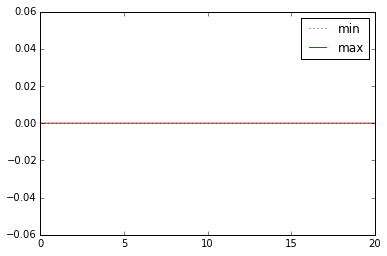

In [25]:
%pylab inline

t = linspace(0, 20, len(temp_logger.temp_max))
plot(t, temp_logger.temp_min,'g:')
plot(t, temp_logger.temp_max,'r-')

legend(('min', 'max'))

## Positions prédéfinies
### Assis

In [4]:
from poppy_humanoid.primitives.posture import SitPosition
robot.attach_primitive(SitPosition(robot),"sit")

In [ ]:
robot.sit.start()

In [5]:
robot.sit.stop()

### Debout

In [10]:
from poppy_humanoid.primitives.posture import StandPosition
robot.attach_primitive(StandPosition(robot),"stand")

In [ ]:
robot.stand.start()

In [9]:
robot.sit.stop();